# Simulation Result Analysor

In [12]:
from datetime import timedelta

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import rc

import matplotlib.font_manager as fm
fm._load_fontmanager()

sns.set_style("ticks")
font = {
	"font.family": "sans-serif",
	"font.size": 8,
}
plt.rcParams.update(font)

# 设置字体
paper_rc = {
	"lines.linewidth": 3,
	"lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.6, rc=paper_rc)
current_palette = sns.color_palette()

pd.set_option("display.max_columns", None)

experiment_name = "Philly"
placer_ls = ["FGD", 'consolidate', 'random']
scheduler_ls = [ 'sjf','fifo', 'qssf', 'srtf'] # , 


log_dir = f"/data/nihaifeng/frag_ratio_1_2/"
trace_dir = f'../data/{experiment_name}'

# vc_list = ['6214e9']
vc_list = list(pd.read_pickle(trace_dir+'/vc_dict_homo.pkl').keys())


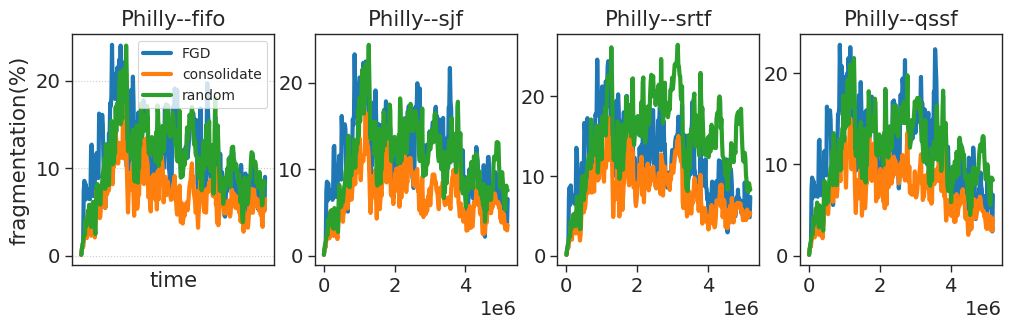

In [23]:
from scipy.interpolate import make_interp_spline
fig, axes = plt.subplots(1, len(scheduler_ls), figsize=(12,3))
axes = axes.flatten() 

for idx, scheduler in enumerate(scheduler_ls):
	ax = axes[idx]
	for placer in placer_ls:
		df = pd.read_csv(log_dir+f'{experiment_name}_{placer}/all/{scheduler}_{placer}_all_seq.csv')
		x = df['time']
		y = df['fragmentation_ration']*100
		x_smooth = np.linspace(x.min(), x.max(), 300)  # 生成300个点
		spl = make_interp_spline(x, y, k=3)  # Cubic interpolation (三次插值)
		y_smooth = spl(x_smooth)

		ax.plot(x_smooth, y_smooth, label=f"{placer}")
		ax.set_title(f'Philly--{scheduler}')

	if idx == 0:
		ax.set_xlabel('time')
		ax.set_xticks([])
		ax.set_ylabel('fragmentation(%)')
		ax.legend(loc='best', fontsize=10)
		ax.grid(linestyle=':')

for i in range(len(vc_list), len(axes)):
	fig.delaxes(axes[i])
plt.show()

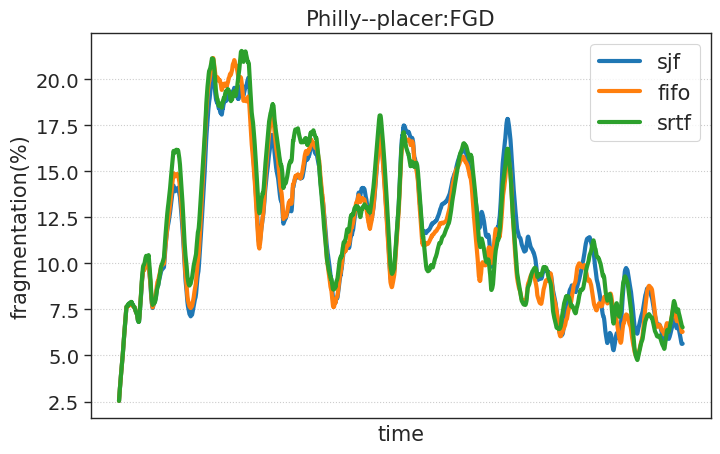

In [35]:
from scipy.interpolate import make_interp_spline

save = False
plt.figure(figsize=(8,5))
placer = placer_ls[0]
window_size = 60*24

for scheduler in scheduler_ls:
	df = pd.read_csv(os.path.join(log_dir,f"{experiment_name}_{placer}/all/{scheduler}_{placer}_all_seq.csv"))
	y = df['fragmentation_ration']*100
	plt.plot(df['time'], y.rolling(window=window_size).mean(), label=f"{scheduler}")

plt.title(f'Philly--placer:{placer}')
plt.xlabel('time', fontsize=15)
plt.xticks([])
plt.ylabel('fragmentation(%)', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.grid(linestyle=':')

if save:
	plt.savefig(os.path.join(log_dir,f"figures/fragmentation_{placer}.pdf"), bbox_inches="tight", dpi=600)
else:
	plt.show()

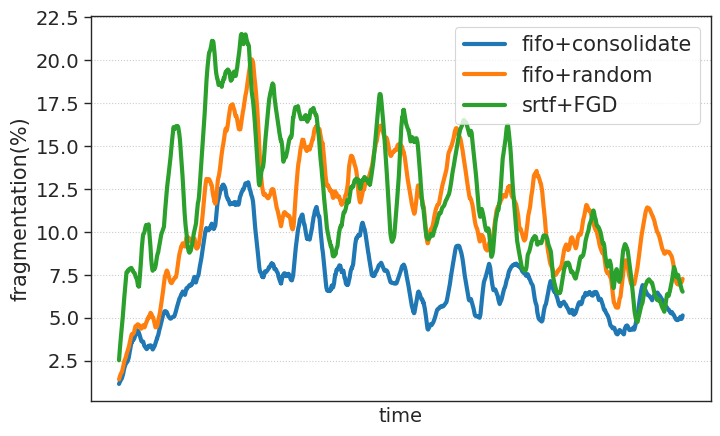

In [34]:
from scipy.interpolate import make_interp_spline

save = True
plt.figure(figsize=(8,5))
cnt = 100
window_size = 60*24

df = pd.read_csv(os.path.join(log_dir,f"{experiment_name}_consolidate/all/fifo_consolidate_all_seq.csv"))
x = df['time']
y = df['fragmentation_ration']*100
y_smooth = y.rolling(window=window_size).mean()
plt.plot(x, y_smooth, label="fifo+consolidate")

df = pd.read_csv(os.path.join(log_dir,f"{experiment_name}_random/all/fifo_random_all_seq.csv"))
x = df['time']
y = df['fragmentation_ration']*100
y_smooth = y.rolling(window=window_size).mean()
plt.plot(x, y_smooth, label="fifo+random")

df = pd.read_csv(os.path.join(log_dir,f"{experiment_name}_FGD/all/srtf_FGD_all_seq.csv"))
x = df['time']
y = df['fragmentation_ration']*100
y_smooth = y.rolling(window=window_size).mean()
plt.plot(x, y_smooth, label="srtf+FGD")


plt.xlabel('time', fontsize=14)
plt.xticks([])
plt.ylabel('fragmentation(%)', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.grid(linestyle=':')

if save:
	plt.savefig(os.path.join(log_dir,f"figures/all.pdf"), bbox_inches="tight", dpi=600)
else:
	plt.show()

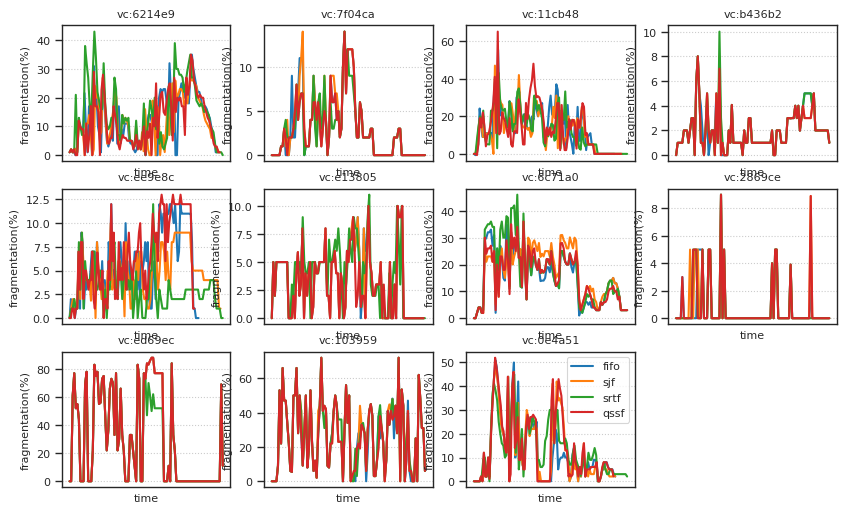

In [37]:
from scipy.interpolate import make_interp_spline

fig, axes = plt.subplots(3, 4, figsize=(10,6))
axes = axes.flatten() 

for idx, vc in enumerate(vc_list):
	ax = axes[idx]
	for scheduler in scheduler_ls:
		df = pd.read_csv(os.path.join(log_dir, f"{vc}/{scheduler}_{placer}_{vc}_seq.csv"))
		
		x = df['time']
		y = df['fragmentation_ration']*100
		x_smooth = np.linspace(x.min(), x.max(), 100)
		spl = make_interp_spline(x, y, k=3)  # Cubic interpolation (三次插值)
		y_smooth = spl(x_smooth)

		ax.plot(x_smooth, y_smooth, label=f"{scheduler}", linewidth=1.5)

	ax.set_title(f'vc:{vc}', fontsize=8)
	ax.set_xlabel('time', fontsize=8)
	ax.set_xticks([])
	ax.tick_params(axis='both', which='major', labelsize=8)
	ax.set_ylabel('fragmentation(%)', fontsize=8)
	ax.grid(linestyle=':')
	if idx == 10:
		ax.legend(loc='best', fontsize=8)


for i in range(len(vc_list), len(axes)):
	fig.delaxes(axes[i])

if save:
	plt.savefig(os.path.join(log_dir,f"figures/fragmentation_{placer}_2.pdf"), bbox_inches="tight", dpi=600)
else:
	plt.show()


## Bar: Queue Time

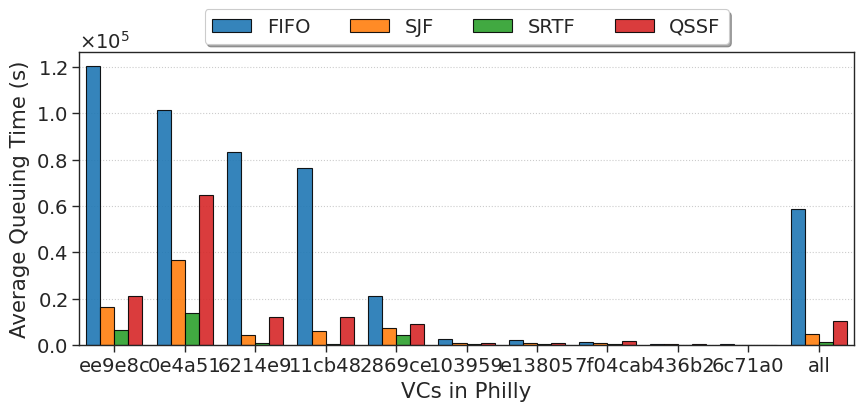

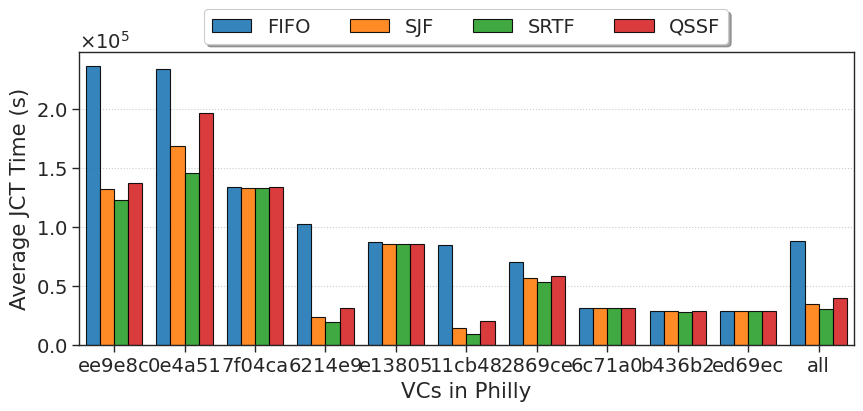

In [32]:
def bar_policies_comparison(df, name, xlabel, save):
	fig, ax = plt.subplots(figsize=(10, 3.8))
	off = 0.25 * (len(df) - 5)
	x = np.arange(1, len(df) + 1)
	width = 0.2

	labels = []
	for c in df.columns:
		labels.append(c.split("_")[0])
		placer = c.split("_")[1]

	for i in range(len(df.columns)):
		offset = i - off
		p1 = ax.bar(
			x + offset * width,
			df.iloc[:, i],
			width,
			alpha=0.9,
			linewidth=0.8,
			edgecolor="k",
			label=labels[i].upper(),
		)
	#         autolabel(p1, ax)

	ax.set_xlabel(f"{xlabel}")
	ax.set_ylabel(f"Average {name} Time (s)")
	ax.set_xticks(x)
	ax.set_xlim(0.5, 11.5)
	ax.set_xticklabels(df.index.values)
	ax.ticklabel_format(axis="y", style="sci", scilimits=(-6, 2), useMathText=True)
	ax.legend(
		loc="upper center",
		bbox_to_anchor=(0.5, 1.18),
		ncol=8,
		fancybox=True,
		shadow=True,
	)
	ax.grid(axis="y", linestyle=":")
	# plt.suptitle(f'{experiment_name}_{xlabel}_{placer}')
	if save:
		fig.savefig(
			f"/data/nihaifeng/log/philly_{placer}/figures/philly_bar_vc_{name}_time.pdf", bbox_inches="tight", dpi=600
		)
	else:
		plt.show()

def draw(df, name, save):		
	que_avg = df.copy()
	all_que = que_avg.loc['all']
	que_avg = que_avg.drop(index='all')
	que_avg.sort_values(by=f'fifo_{placer}', ascending=False, inplace=True)
	que_avg = que_avg.head(10)
	que_avg.loc['all'] = all_que.values

	bar_policies_comparison(que_avg, name, xlabel=f"VCs in Philly", save=save)


jct_avg = pd.read_csv(f"{log_dir}/{experiment_name}_{placer}/jct_avg_{placer}.csv", index_col=0)
_que_avg = pd.read_csv(f"{log_dir}{experiment_name}_{placer}//que_avg_{placer}.csv", index_col=0)

draw(_que_avg, 'Queuing', False)
draw(jct_avg, 'JCT', False)